# Import

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf

INFO:tensorflow:Using local port 16865
INFO:tensorflow:Using local port 17223
INFO:tensorflow:Using local port 19441
INFO:tensorflow:Using local port 23511
INFO:tensorflow:Using local port 17156
INFO:tensorflow:Using local port 21640
INFO:tensorflow:Using local port 23096
INFO:tensorflow:Using local port 19024
INFO:tensorflow:Using local port 19779
INFO:tensorflow:Using local port 22330


In [2]:
sys.path.append('../../')

In [3]:
from test_fast_inference.data import *
from test_fast_inference.tensorflow_tensorrt_conversion import *

/home/justin/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


# Train

In [4]:
# Config
batch_size = 28
num_batches = 20
num_epochs = 280000//(batch_size*num_batches)
lr = 1e-3

# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Metrics
metrics = [
    tf.keras.metrics.SparseCategoricalCrossentropy(),
    tf.keras.metrics.SparseCategoricalAccuracy()
]

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Model
in_channels  = 1
out_channels = 5
layout_encoder = [[[32,5,2]],
                  [[32,3,1],[32,3,2]],
                  [[64,3,1],[64,3,2]],
                  [[128,3,1],[128,3,2]]]
model = UNET_TRT(get_encoder(in_channels, layout_encoder), out_channels)

Training dataset is large so won't be cacheable in memory

In [5]:
ds_trn = (
    tf.data.TFRecordDataset(['/data/fiducial_detect/trn/tfrecord/trn.tfrecord'])
    .map(preprocess_tfrecord)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

Validation dataset is small so cache it in memory

In [6]:
ds_val = (
    tf.data.Dataset.list_files('/data/fiducial_detect/val/*_mask.png', shuffle=False)
    .map(preprocess_file)
    .batch(batch_size)
    .cache()
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

Train

In [7]:
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/best.tf', 
    monitor='val_sparse_categorical_accuracy', 
    save_best_only=True,
    mode='auto', 
    save_freq='epoch'
)

In [8]:
model.compile(optimizer, loss, metrics)
model_history = model.fit(ds_trn,
                          epochs=num_epochs,
                          steps_per_epoch=num_batches,
                          validation_data=ds_val,
                          callbacks=callback_checkpoint)

Epoch 1/500
20/20 [==============================] - 11s 331ms/step - loss: 1.3524 - sparse_categorical_crossentropy: 3.7630 - sparse_categorical_accuracy: 0.5237 - val_loss: 0.3546 - val_sparse_categorical_crossentropy: 0.1459 - val_sparse_categorical_accuracy: 0.9909
Epoch 2/500
20/20 [==============================] - 6s 291ms/step - loss: 0.1987 - sparse_categorical_crossentropy: 0.1012 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.0493 - val_sparse_categorical_crossentropy: 0.1464 - val_sparse_categorical_accuracy: 0.9909
Epoch 3/500
20/20 [==============================] - 6s 291ms/step - loss: 0.0296 - sparse_categorical_crossentropy: 0.1014 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.0240 - val_sparse_categorical_crossentropy: 0.1405 - val_sparse_categorical_accuracy: 0.9909
Epoch 4/500
20/20 [==============================] - 6s 291ms/step - loss: 0.0169 - sparse_categorical_crossentropy: 0.0943 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.0213 - val_spars

20/20 [==============================] - 6s 294ms/step - loss: 0.0115 - sparse_categorical_crossentropy: 0.0911 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.0163 - val_sparse_categorical_crossentropy: 0.1310 - val_sparse_categorical_accuracy: 0.9909
Epoch 32/500
20/20 [==============================] - 6s 294ms/step - loss: 0.0117 - sparse_categorical_crossentropy: 0.0924 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.0162 - val_sparse_categorical_crossentropy: 0.1305 - val_sparse_categorical_accuracy: 0.9909
Epoch 33/500
20/20 [==============================] - 6s 294ms/step - loss: 0.0110 - sparse_categorical_crossentropy: 0.0868 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.0162 - val_sparse_categorical_crossentropy: 0.1296 - val_sparse_categorical_accuracy: 0.9909
Epoch 34/500
20/20 [==============================] - 6s 293ms/step - loss: 0.0112 - sparse_categorical_crossentropy: 0.0884 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.0163 - val_sparse_categori

20/20 [==============================] - 6s 294ms/step - loss: 0.0099 - sparse_categorical_crossentropy: 0.0182 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.0144 - val_sparse_categorical_crossentropy: 0.0270 - val_sparse_categorical_accuracy: 0.9929
Epoch 62/500
20/20 [==============================] - 6s 294ms/step - loss: 0.0101 - sparse_categorical_crossentropy: 0.0182 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0143 - val_sparse_categorical_crossentropy: 0.0257 - val_sparse_categorical_accuracy: 0.9929
Epoch 63/500
20/20 [==============================] - 6s 294ms/step - loss: 0.0103 - sparse_categorical_crossentropy: 0.0179 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0144 - val_sparse_categorical_crossentropy: 0.0273 - val_sparse_categorical_accuracy: 0.9929
Epoch 64/500
20/20 [==============================] - 6s 294ms/step - loss: 0.0100 - sparse_categorical_crossentropy: 0.0176 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0143 - val_sparse_categori

20/20 [==============================] - 6s 295ms/step - loss: 0.0098 - sparse_categorical_crossentropy: 0.0142 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0134 - val_sparse_categorical_crossentropy: 0.0205 - val_sparse_categorical_accuracy: 0.9930
Epoch 92/500
20/20 [==============================] - 6s 295ms/step - loss: 0.0094 - sparse_categorical_crossentropy: 0.0138 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.0139 - val_sparse_categorical_crossentropy: 0.0239 - val_sparse_categorical_accuracy: 0.9929
Epoch 93/500
20/20 [==============================] - 6s 294ms/step - loss: 0.0094 - sparse_categorical_crossentropy: 0.0140 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.0135 - val_sparse_categorical_crossentropy: 0.0218 - val_sparse_categorical_accuracy: 0.9930
Epoch 94/500
20/20 [==============================] - 6s 294ms/step - loss: 0.0092 - sparse_categorical_crossentropy: 0.0136 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.0136 - val_sparse_categori

20/20 [==============================] - 6s 295ms/step - loss: 0.0092 - sparse_categorical_crossentropy: 0.0123 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.0135 - val_sparse_categorical_crossentropy: 0.0217 - val_sparse_categorical_accuracy: 0.9931
Epoch 122/500
20/20 [==============================] - 6s 295ms/step - loss: 0.0095 - sparse_categorical_crossentropy: 0.0127 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0133 - val_sparse_categorical_crossentropy: 0.0205 - val_sparse_categorical_accuracy: 0.9931
Epoch 123/500
20/20 [==============================] - 6s 295ms/step - loss: 0.0090 - sparse_categorical_crossentropy: 0.0121 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.0137 - val_sparse_categorical_crossentropy: 0.0226 - val_sparse_categorical_accuracy: 0.9930
Epoch 124/500
20/20 [==============================] - 6s 294ms/step - loss: 0.0091 - sparse_categorical_crossentropy: 0.0123 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.0134 - val_sparse_categ

20/20 [==============================] - 6s 295ms/step - loss: 0.0088 - sparse_categorical_crossentropy: 0.0117 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.0134 - val_sparse_categorical_crossentropy: 0.0207 - val_sparse_categorical_accuracy: 0.9930
Epoch 152/500
20/20 [==============================] - 6s 294ms/step - loss: 0.0087 - sparse_categorical_crossentropy: 0.0118 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0136 - val_sparse_categorical_crossentropy: 0.0215 - val_sparse_categorical_accuracy: 0.9931
Epoch 153/500
20/20 [==============================] - 6s 294ms/step - loss: 0.0089 - sparse_categorical_crossentropy: 0.0118 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0134 - val_sparse_categorical_crossentropy: 0.0205 - val_sparse_categorical_accuracy: 0.9932
Epoch 154/500
20/20 [==============================] - 6s 295ms/step - loss: 0.0089 - sparse_categorical_crossentropy: 0.0116 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.0134 - val_sparse_categ

20/20 [==============================] - 6s 294ms/step - loss: 0.0031 - sparse_categorical_crossentropy: 0.0125 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.0044 - val_sparse_categorical_crossentropy: 0.0131 - val_sparse_categorical_accuracy: 0.9983
Epoch 182/500
20/20 [==============================] - 6s 295ms/step - loss: 0.0022 - sparse_categorical_crossentropy: 0.0119 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.0022 - val_sparse_categorical_crossentropy: 0.0123 - val_sparse_categorical_accuracy: 0.9995
Epoch 183/500
20/20 [==============================] - 6s 294ms/step - loss: 0.0017 - sparse_categorical_crossentropy: 0.0113 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.0097 - val_sparse_categorical_crossentropy: 0.0141 - val_sparse_categorical_accuracy: 0.9965
Epoch 184/500
20/20 [==============================] - 6s 294ms/step - loss: 0.0020 - sparse_categorical_crossentropy: 0.0136 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0027 - val_sparse_categ

Epoch 211/500
20/20 [==============================] - 6s 294ms/step - loss: 5.5313e-04 - sparse_categorical_crossentropy: 0.0142 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0012 - val_sparse_categorical_crossentropy: 0.0133 - val_sparse_categorical_accuracy: 0.9996
Epoch 212/500
20/20 [==============================] - 6s 295ms/step - loss: 5.6570e-04 - sparse_categorical_crossentropy: 0.0147 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0014 - val_sparse_categorical_crossentropy: 0.0128 - val_sparse_categorical_accuracy: 0.9996
Epoch 213/500
20/20 [==============================] - 6s 295ms/step - loss: 7.2877e-04 - sparse_categorical_crossentropy: 0.0132 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0011 - val_sparse_categorical_crossentropy: 0.0130 - val_sparse_categorical_accuracy: 0.9996
Epoch 214/500
20/20 [==============================] - 6s 294ms/step - loss: 5.9901e-04 - sparse_categorical_crossentropy: 0.0163 - sparse_categorical_accuracy: 0.9998 - val_l

Epoch 241/500
20/20 [==============================] - 6s 294ms/step - loss: 4.0862e-04 - sparse_categorical_crossentropy: 0.0132 - sparse_categorical_accuracy: 0.9998 - val_loss: 8.5366e-04 - val_sparse_categorical_crossentropy: 0.0130 - val_sparse_categorical_accuracy: 0.9997
Epoch 242/500
20/20 [==============================] - 6s 295ms/step - loss: 5.1418e-04 - sparse_categorical_crossentropy: 0.0135 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0017 - val_sparse_categorical_crossentropy: 0.0127 - val_sparse_categorical_accuracy: 0.9995
Epoch 243/500
20/20 [==============================] - 6s 294ms/step - loss: 5.0605e-04 - sparse_categorical_crossentropy: 0.0144 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0011 - val_sparse_categorical_crossentropy: 0.0134 - val_sparse_categorical_accuracy: 0.9996
Epoch 244/500
20/20 [==============================] - 6s 294ms/step - loss: 3.9630e-04 - sparse_categorical_crossentropy: 0.0138 - sparse_categorical_accuracy: 0.9998 - v

Epoch 271/500
20/20 [==============================] - 6s 295ms/step - loss: 4.2134e-04 - sparse_categorical_crossentropy: 0.0131 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0012 - val_sparse_categorical_crossentropy: 0.0120 - val_sparse_categorical_accuracy: 0.9996
Epoch 272/500
20/20 [==============================] - 6s 294ms/step - loss: 3.5401e-04 - sparse_categorical_crossentropy: 0.0122 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0010 - val_sparse_categorical_crossentropy: 0.0124 - val_sparse_categorical_accuracy: 0.9997
Epoch 273/500
20/20 [==============================] - 6s 294ms/step - loss: 3.6967e-04 - sparse_categorical_crossentropy: 0.0131 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0014 - val_sparse_categorical_crossentropy: 0.0120 - val_sparse_categorical_accuracy: 0.9996
Epoch 274/500
20/20 [==============================] - 6s 295ms/step - loss: 4.6892e-04 - sparse_categorical_crossentropy: 0.0129 - sparse_categorical_accuracy: 0.9998 - val_l

Epoch 301/500
20/20 [==============================] - 6s 294ms/step - loss: 3.6165e-04 - sparse_categorical_crossentropy: 0.0103 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0012 - val_sparse_categorical_crossentropy: 0.0118 - val_sparse_categorical_accuracy: 0.9996
Epoch 302/500
20/20 [==============================] - 6s 295ms/step - loss: 3.3156e-04 - sparse_categorical_crossentropy: 0.0101 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0011 - val_sparse_categorical_crossentropy: 0.0117 - val_sparse_categorical_accuracy: 0.9996
Epoch 303/500
20/20 [==============================] - 6s 295ms/step - loss: 4.5216e-04 - sparse_categorical_crossentropy: 0.0103 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0011 - val_sparse_categorical_crossentropy: 0.0116 - val_sparse_categorical_accuracy: 0.9996
Epoch 304/500
20/20 [==============================] - 6s 295ms/step - loss: 4.9268e-04 - sparse_categorical_crossentropy: 0.0115 - sparse_categorical_accuracy: 0.9998 - val_l

Epoch 331/500
20/20 [==============================] - 6s 294ms/step - loss: 4.8796e-04 - sparse_categorical_crossentropy: 0.0097 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0011 - val_sparse_categorical_crossentropy: 0.0119 - val_sparse_categorical_accuracy: 0.9996
Epoch 332/500
20/20 [==============================] - 6s 295ms/step - loss: 4.8271e-04 - sparse_categorical_crossentropy: 0.0095 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0010 - val_sparse_categorical_crossentropy: 0.0119 - val_sparse_categorical_accuracy: 0.9996
Epoch 333/500
20/20 [==============================] - 6s 294ms/step - loss: 4.9490e-04 - sparse_categorical_crossentropy: 0.0097 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0014 - val_sparse_categorical_crossentropy: 0.0117 - val_sparse_categorical_accuracy: 0.9995
Epoch 334/500
20/20 [==============================] - 6s 295ms/step - loss: 5.8314e-04 - sparse_categorical_crossentropy: 0.0097 - sparse_categorical_accuracy: 0.9998 - val_l

Epoch 361/500
20/20 [==============================] - 6s 295ms/step - loss: 5.1181e-04 - sparse_categorical_crossentropy: 0.0090 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0010 - val_sparse_categorical_crossentropy: 0.0116 - val_sparse_categorical_accuracy: 0.9996
Epoch 362/500
20/20 [==============================] - 6s 294ms/step - loss: 4.3226e-04 - sparse_categorical_crossentropy: 0.0095 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0012 - val_sparse_categorical_crossentropy: 0.0115 - val_sparse_categorical_accuracy: 0.9996
Epoch 363/500
20/20 [==============================] - 6s 294ms/step - loss: 3.0337e-04 - sparse_categorical_crossentropy: 0.0091 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0010 - val_sparse_categorical_crossentropy: 0.0116 - val_sparse_categorical_accuracy: 0.9996
Epoch 364/500
20/20 [==============================] - 6s 294ms/step - loss: 3.3962e-04 - sparse_categorical_crossentropy: 0.0094 - sparse_categorical_accuracy: 0.9999 - val_l

Epoch 391/500
20/20 [==============================] - 6s 294ms/step - loss: 3.1767e-04 - sparse_categorical_crossentropy: 0.0092 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0012 - val_sparse_categorical_crossentropy: 0.0114 - val_sparse_categorical_accuracy: 0.9996
Epoch 392/500
20/20 [==============================] - 6s 294ms/step - loss: 3.0116e-04 - sparse_categorical_crossentropy: 0.0087 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0014 - val_sparse_categorical_crossentropy: 0.0112 - val_sparse_categorical_accuracy: 0.9996
Epoch 393/500
20/20 [==============================] - 6s 295ms/step - loss: 4.0506e-04 - sparse_categorical_crossentropy: 0.0087 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0012 - val_sparse_categorical_crossentropy: 0.0115 - val_sparse_categorical_accuracy: 0.9996
Epoch 394/500
20/20 [==============================] - 6s 294ms/step - loss: 3.9001e-04 - sparse_categorical_crossentropy: 0.0094 - sparse_categorical_accuracy: 0.9999 - val_l

Epoch 421/500
20/20 [==============================] - 6s 294ms/step - loss: 3.5420e-04 - sparse_categorical_crossentropy: 0.0088 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0012 - val_sparse_categorical_crossentropy: 0.0115 - val_sparse_categorical_accuracy: 0.9996
Epoch 422/500
20/20 [==============================] - 6s 294ms/step - loss: 3.0525e-04 - sparse_categorical_crossentropy: 0.0087 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0012 - val_sparse_categorical_crossentropy: 0.0114 - val_sparse_categorical_accuracy: 0.9996
Epoch 423/500
20/20 [==============================] - 6s 294ms/step - loss: 3.1138e-04 - sparse_categorical_crossentropy: 0.0088 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0014 - val_sparse_categorical_crossentropy: 0.0113 - val_sparse_categorical_accuracy: 0.9996
Epoch 424/500
20/20 [==============================] - 6s 294ms/step - loss: 2.6607e-04 - sparse_categorical_crossentropy: 0.0085 - sparse_categorical_accuracy: 0.9999 - val_l

Epoch 451/500
20/20 [==============================] - 6s 294ms/step - loss: 4.1115e-04 - sparse_categorical_crossentropy: 0.0086 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0013 - val_sparse_categorical_crossentropy: 0.0113 - val_sparse_categorical_accuracy: 0.9996
Epoch 452/500
20/20 [==============================] - 6s 295ms/step - loss: 3.8226e-04 - sparse_categorical_crossentropy: 0.0084 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0020 - val_sparse_categorical_crossentropy: 0.0111 - val_sparse_categorical_accuracy: 0.9995
Epoch 453/500
20/20 [==============================] - 6s 294ms/step - loss: 3.2524e-04 - sparse_categorical_crossentropy: 0.0086 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0012 - val_sparse_categorical_crossentropy: 0.0114 - val_sparse_categorical_accuracy: 0.9996
Epoch 454/500
20/20 [==============================] - 6s 294ms/step - loss: 3.4136e-04 - sparse_categorical_crossentropy: 0.0086 - sparse_categorical_accuracy: 0.9999 - val_l

Epoch 481/500
20/20 [==============================] - 6s 294ms/step - loss: 2.8918e-04 - sparse_categorical_crossentropy: 0.0083 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0013 - val_sparse_categorical_crossentropy: 0.0112 - val_sparse_categorical_accuracy: 0.9996
Epoch 482/500
20/20 [==============================] - 6s 294ms/step - loss: 2.6530e-04 - sparse_categorical_crossentropy: 0.0082 - sparse_categorical_accuracy: 0.9999 - val_loss: 9.7812e-04 - val_sparse_categorical_crossentropy: 0.0115 - val_sparse_categorical_accuracy: 0.9997
Epoch 483/500
20/20 [==============================] - 6s 294ms/step - loss: 2.6287e-04 - sparse_categorical_crossentropy: 0.0083 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0012 - val_sparse_categorical_crossentropy: 0.0115 - val_sparse_categorical_accuracy: 0.9996
Epoch 484/500
20/20 [==============================] - 6s 295ms/step - loss: 3.2290e-04 - sparse_categorical_crossentropy: 0.0083 - sparse_categorical_accuracy: 0.9999 - v

# Test

In [9]:
model.load_weights('checkpoints/best.tf')

In [12]:
for X,y in ds_val.take(1):
    pass

In [14]:
y_hat = model.predict(X)

In [21]:
idx = 0

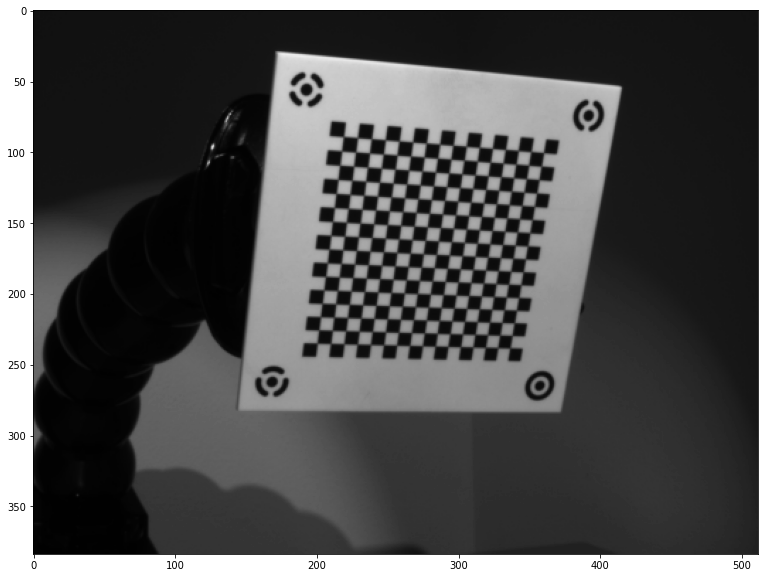

In [24]:
plt.figure(figsize=(15,10))
plt.imshow(X[idx], cmap='gray', vmin=-1, vmax=1)

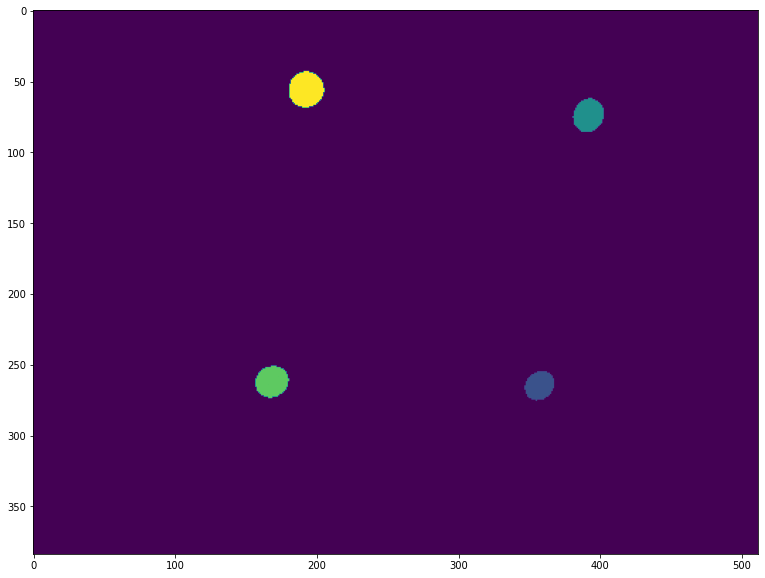

In [25]:
plt.figure(figsize=(15,10))
plt.imshow(tf.argmax(y_hat, axis=3)[idx])

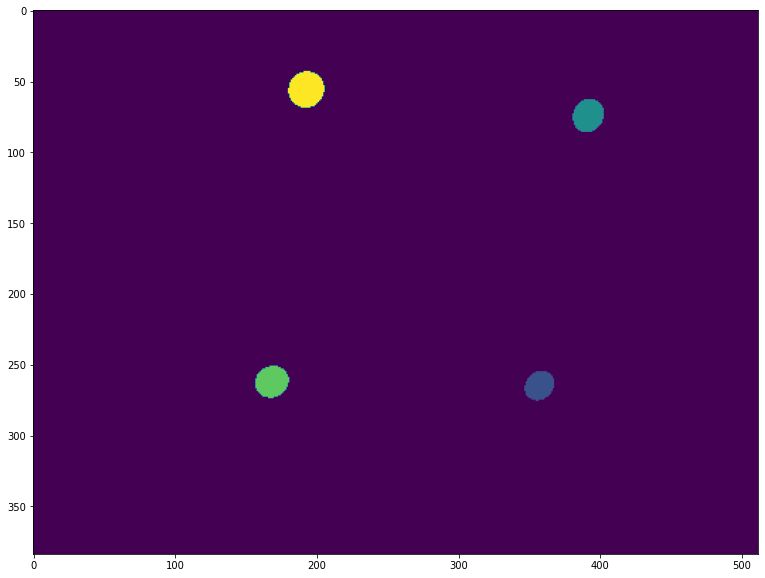

In [26]:
plt.figure(figsize=(15,10))
plt.imshow(y[idx])

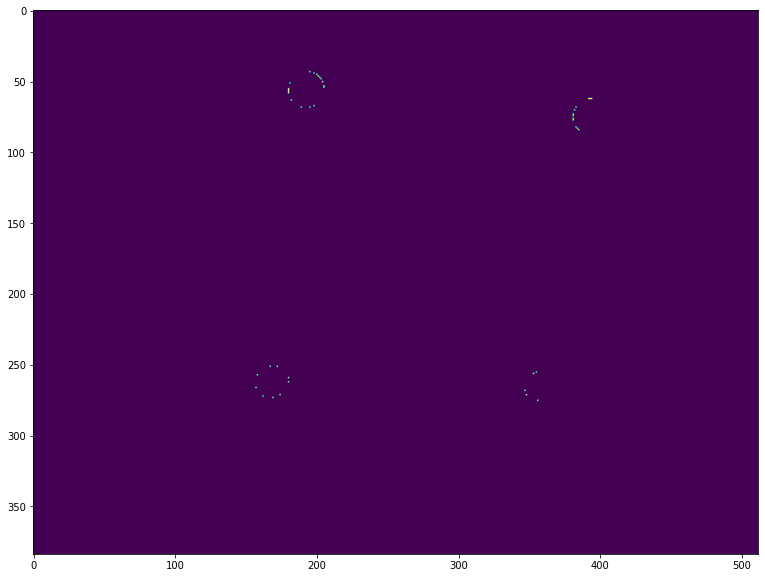

In [37]:
plt.figure(figsize=(15,10))
plt.imshow(tf.math.not_equal(tf.argmax(y_hat, axis=3)[idx], tf.squeeze(y[idx])))